## Radius measurement at different z-sections

Until now, the colony images were taken through ~4mm agar. The GFP signal got distorted, and very noisy images were formed. The formed noise made it very hard to automate height measurements. Even with a naked eye, it was close to impossible to find the top of the colony. In this example, Glu 04/17/2021 and Gly 04/17/2021, there is nothing in between the lens and the colony, so the GFP signal is very clear. This opens up the possibility of automated radius and height measurements!

In [1]:
%matplotlib notebook

# Dependencies

import os
import cv2
import merging_functions as mf
import numpy as np
import tracker as tr

from matplotlib import pyplot as plt

from bs4 import BeautifulSoup

### Let's try with a single image where colony is clear.
The purpose at this point is to look at some parameters, where the radius can be measured for an arbitrary z-section

In [14]:
exp_name = "EQ59_Glu_04172021"
plt_ids = [1,1,1,2,2,3,3,3,4,4,5,5]
tp_ids = [2,8,12,3,7,1,6,11,5,10,4,9]

# exp_name = "EQ59_Gly_04172021"
# plt_ids = [3,2,1,4,3,2,1,5,4,3,2,1]
# tp_ids = [1,2,3,4,5,6,7,8,9,10,11,12]
exp_folder = os.path.join("E:", "Tolga", f"{exp_name}")
acq_name_lst = []
for ix in range(len(plt_ids)):
    acq_name = f"TileScan_Plt{plt_ids[ix]}_Tp{tp_ids[ix]}"
    acq_name_lst.append(acq_name)
    
pix = 8
plt_id = plt_ids[pix]
tp_id = tp_ids[pix]
print(f"plt_id = {plt_id}, tp_id = {tp_id}")
acq_name = f"TileScan_Plt{plt_id}_Tp{tp_id}"
inner = True

plt_id = 4, tp_id = 5


In [33]:
metadata = mf.collect_metadata(exp_folder, exp_name, acq_name, inner=inner)


78

In [36]:
# Go through each timepoint and each frame to collect the pixel and their locations that exceeds the threshold
def get_image_sequence(merged_folder, exp_name, acq_name, t_str):
    # Run through a single timepoint
    merged_acq_folder = os.path.join(merged_folder, f"{exp_name}_{acq_name}")
    
    znum = metadata["dimensions"]["Z"]["NumberOfElements"]
    # Find the number of digits
    znum_digit = len(str(znum))
    # zstr for file path
    zstr_holder = f"z%0{znum_digit}d"
    
    img_seq = np.zeros((512, 512, znum), np.uint8)
    for zix in range(znum):
        print(f"Preparing {zix}/{znum}", end="\r", flush=True)
        zstr = zstr_holder % (zix)
        fpath_merged = os.path.join(merged_acq_folder, f"{exp_name}_{acq_name}_Merged_{tstr}_{zstr}.tif")
            
        # Read frmae
        img = cv2.imread(fpath_merged)
        img_blur = cv2.GaussianBlur(img, (11,11), 0)
        # Add contrast for better visualization.
        alpha = 20
        beta = -10
        img_contrast = np.uint8(np.clip(alpha*img_blur + beta, 0, 255))
        # Resize for video output
        img_resized = cv2.resize(img_contrast, dim)
        img_resized_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        # Contrast 
        img_seq[:,:,zix] = img_resized_gray
        
    return img_seq

In [37]:
tstr = "t0"
zstr = "z20"

# Read an image
merged_folder = os.path.join(exp_folder, "Merged")

img_seq = get_image_sequence(merged_folder, exp_name, acq_name, tstr)

<IPython.core.display.Javascript object>


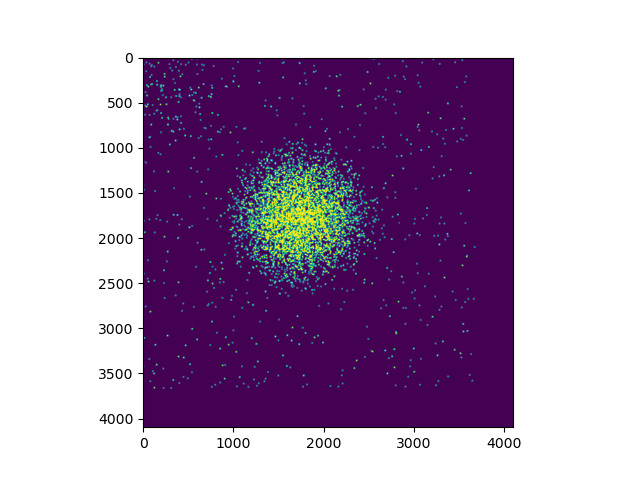

In [77]:
# img = img_seq[:,:,28]
tstr = "t0"
zstr = "z40"
# Read an image
merged_folder = os.path.join(exp_folder, "Merged")
fpath_merged = os.path.join(merged_acq_folder, f"{exp_name}_{acq_name}_Merged_{tstr}_{zstr}.tif")

img = cv2.imread(fpath_merged)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_filtered = cv2.boxFilter(img_gray, -1, (16,16), normalize=False)

fig, ax= plt.subplots()
ax.imshow(cv2.GaussianBlur(img_filtered, (11,11), 0))


In [68]:
img_filtered.shape

(4096, 4096, 3)

<IPython.core.display.Javascript object>


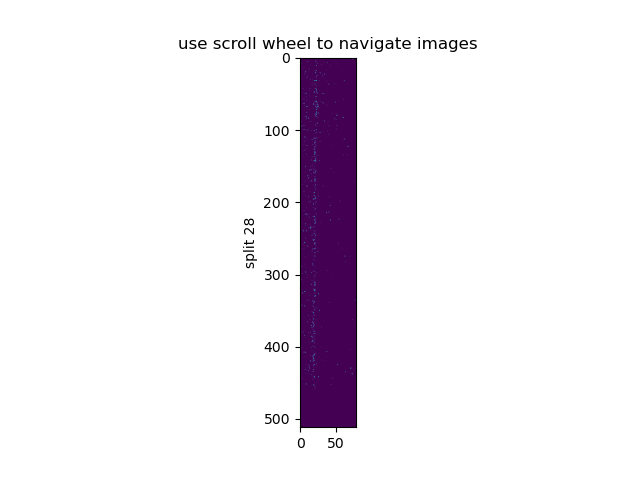

In [42]:
# Plot the image sequence in a figure
fig_maxint_img, ax = plt.subplots()
tracker = tr.IndexTracker(ax, img_seq, "image", None, 20)#, args_dict)

fig_maxint_img.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [11]:
img.resize((512,512))

In [14]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)